# Indicators of Heart Disase (2022 Update)
`Data Set link: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease`

# Import & Datensatz

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.inspection import permutation_importance

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, true_positive_rate,false_positive_rate

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy as np

In [3]:
df = pd.read_csv("heart_2020_cleaned.csv")
df_orginal = df.copy()

In [4]:
styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.600000,Yes,No,No,3.000000,30.000000,No,Female,55-59,White,Yes,Yes,Very good,5.000000,Yes,No,Yes
1,No,20.340000,No,No,Yes,0.000000,0.000000,No,Female,80 or older,White,No,Yes,Very good,7.000000,No,No,No
2,No,26.580000,Yes,No,No,20.000000,30.000000,No,Male,65-69,White,Yes,Yes,Fair,8.000000,Yes,No,No
3,No,24.210000,No,No,No,0.000000,0.000000,No,Female,75-79,White,No,No,Good,6.000000,No,No,Yes
4,No,23.710000,No,No,No,28.000000,0.000000,Yes,Female,40-44,White,No,Yes,Very good,8.000000,No,No,No
5,Yes,28.870000,Yes,No,No,6.000000,0.000000,Yes,Female,75-79,Black,No,No,Fair,12.000000,No,No,No
6,No,21.630000,No,No,No,15.000000,0.000000,No,Female,70-74,White,No,Yes,Fair,4.000000,Yes,No,Yes
7,No,31.640000,Yes,No,No,5.000000,0.000000,Yes,Female,80 or older,White,Yes,No,Good,9.000000,Yes,No,No
8,No,26.450000,No,No,No,0.000000,0.000000,No,Female,80 or older,White,"No, borderline diabetes",No,Fair,5.000000,No,Yes,No
9,No,40.690000,No,No,No,0.000000,0.000000,Yes,Male,65-69,White,No,Yes,Good,10.000000,No,No,No


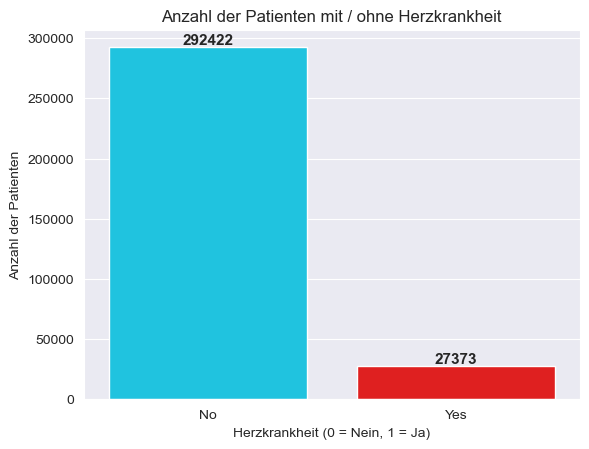

Anzahl der Zeilen (Patienten): 319795
Anzahl der Spalten (Features): 18


In [5]:
ax = sns.countplot(x='HeartDisease', hue='HeartDisease', data=df, palette=['#00d9ff', '#ff0000'], legend=False)

plt.title('Anzahl der Patienten mit / ohne Herzkrankheit')
plt.xlabel('Herzkrankheit (0 = Nein, 1 = Ja)')
plt.ylabel('Anzahl der Patienten')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

plt.show()
print(f"Anzahl der Zeilen (Patienten): {df.shape[0]}")
print(f"Anzahl der Spalten (Features): {df.shape[1]}")

# Daten Vorverarbeitung

## Duplikate & Fehlende Werte

In [6]:
duplikate_df = df[df.duplicated(keep=False)]

anzahl_duplikate = len(duplikate_df)
gesamt = len(df)
prozent_duplikate = (anzahl_duplikate / gesamt) * 100

# Verteilung HeartDisease in den Duplikaten
verteilung_duplikate = duplikate_df['HeartDisease'].value_counts(normalize=True) * 100

# Verteilung HeartDisease im gesamten DataFrame
verteilung_gesamt = df['HeartDisease'].value_counts(normalize=True) * 100

# Ausgabe
print("Gesamtzeilen:", gesamt)
print("Anzahl mehrfach vorkommender Zeilen:", anzahl_duplikate)
print(f"Prozent mehrfach vorkommend: {prozent_duplikate:.2f}%\n")

print("Verteilung von Heartdisease innerhalb der Duplikate:")
if not verteilung_duplikate.empty:
    for wert, proz in verteilung_duplikate.items():
        print(f"  {wert}: {proz:.2f}%")
else:
    print("    - - -")

print("\nGesamtverteilung HeartDisease:")
for wert, proz in verteilung_gesamt.items():
    print(f"  {wert}: {proz:.2f}%")

Gesamtzeilen: 319795
Anzahl mehrfach vorkommender Zeilen: 29930
Prozent mehrfach vorkommend: 9.36%

Verteilung von Heartdisease innerhalb der Duplikate:
  No: 99.27%
  Yes: 0.73%

Gesamtverteilung HeartDisease:
  No: 91.44%
  Yes: 8.56%


In [7]:
df = df.drop_duplicates()

In [8]:
print("Fehlende Werte: ")
print(df.isnull().sum())

Fehlende Werte: 
HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64


## Typprüfung

In [9]:
def check_values(column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte '{column_type}' nicht im Datensatz gefunden.")
        return

    values = df[column_type].dropna().unique()
    invalid = set(values).difference(set(valid_values))
    if invalid:
         print(f" Ungültige Werte in Spalte '{column_type}': {invalid} ")
    else:
        print(f"Alle Werte in Spalte '{column_type}' sind gültig ")

valid_values_dict = {
    "Sex": {'Male', 'Female'},
    "Smoking": {'Yes', 'No'},
    "AlcoholDrinking": {'Yes', 'No'},
    "Diabetic": {
        'Yes', 'No',
        'No, borderline diabetes',
        'Yes (during pregnancy)'
    },
    "GenHealth": {'Excellent', 'Very good', 'Good', 'Fair', 'Poor'},
    "Race": {
        'White', 'Black', 'Asian',
        'American Indian/Alaskan Native',
        'Other', 'Hispanic'
    },
    "AgeCategory": {
        '18-24', '25-29', '30-34', '35-39', '40-44', '45-49',
        '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older'
    },
    "Asthma": {'Yes', 'No'},
    "KidneyDisease": {'Yes', 'No'},
    "SkinCancer": {'Yes', 'No'},
    "Stroke": {'Yes', 'No'},
    "DiffWalking": {'Yes', 'No'},
    "PhysicalActivity": {'Yes', 'No'},
    "HeartDisease": {'Yes', 'No'}
}


def check_if_numeric (column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte {column_type}' nicht im Datensatz gefunden.")
        return
    else:
        non_numeric = df[column_type].dropna().apply(lambda x: not isinstance(x, (int, float)))
        if non_numeric.any():
            count_invalid = non_numeric.sum()
            print(f"{count_invalid} nicht numerische Werte in Spalte '{column_type}'")
            print(f"Beispiele: {df[column_type][non_numeric].unique()[:5]}")
        else:
            print(f"Alle Werte in Spalte '{column_type}' sind numerisch.")

numeric_columns = [
    'BMI',
    'PhysicalHealth',
    'MentalHealth',
    'SleepTime',
]


# Anwendung:
for column, valid_set in valid_values_dict.items():
    check_values(column, valid_set)

for col in numeric_columns:
    check_if_numeric(col, numeric_columns)

Alle Werte in Spalte 'Sex' sind gültig 
Alle Werte in Spalte 'Smoking' sind gültig 
Alle Werte in Spalte 'AlcoholDrinking' sind gültig 
Alle Werte in Spalte 'Diabetic' sind gültig 
Alle Werte in Spalte 'GenHealth' sind gültig 
Alle Werte in Spalte 'Race' sind gültig 
Alle Werte in Spalte 'AgeCategory' sind gültig 
Alle Werte in Spalte 'Asthma' sind gültig 
Alle Werte in Spalte 'KidneyDisease' sind gültig 
Alle Werte in Spalte 'SkinCancer' sind gültig 
Alle Werte in Spalte 'Stroke' sind gültig 
Alle Werte in Spalte 'DiffWalking' sind gültig 
Alle Werte in Spalte 'PhysicalActivity' sind gültig 
Alle Werte in Spalte 'HeartDisease' sind gültig 
Alle Werte in Spalte 'BMI' sind numerisch.
Alle Werte in Spalte 'PhysicalHealth' sind numerisch.
Alle Werte in Spalte 'MentalHealth' sind numerisch.
Alle Werte in Spalte 'SleepTime' sind numerisch.


## Unrealistische Werte
Unrealistische Werte werden in diesem Datensatz einfach entfernt, da dies aufgrund der vielen Daten kein Problem ist

In [10]:
print(f"Anzahl an Zeilen: {len(df)}")

def check_unrealistic_values(columnName, min_val, max_val):
    series = df[columnName]
    _df = df[(df[columnName] >= min_val) & (df[columnName] <= max_val)]
    invalid = series[(series < min_val) | (series > max_val)]
    print(f"{columnName}: {len(invalid)} Werte außerhalb des akzeptieren Bereichs '{min_val}-{max_val}'")
    return _df


df = check_unrealistic_values('BMI', 12, 70)
df = check_unrealistic_values('SleepTime', 2, 18)


print(f"Neue Anzahl an Zeilen: {len(df)}")

Anzahl an Zeilen: 301717
BMI: 129 Werte außerhalb des akzeptieren Bereichs '12-70'
SleepTime: 662 Werte außerhalb des akzeptieren Bereichs '2-18'
Neue Anzahl an Zeilen: 300926


## Bias/ Korrelation

Altersverteilung
count     300926
unique        13
top        65-69
freq       31598
Name: AgeCategory, dtype: object


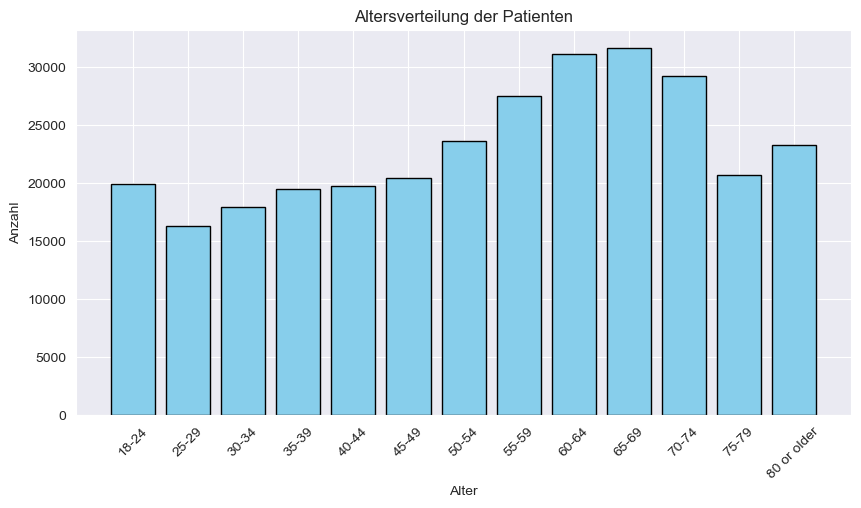

In [11]:
print("Altersverteilung")
print(df['AgeCategory'].describe())

age_order = [
    '18-24', '25-29', '30-34', '35-39', '40-44',
    '45-49', '50-54', '55-59', '60-64', '65-69',
    '70-74', '75-79', '80 or older'
]

age_counts = df['AgeCategory'].value_counts().reindex(age_order)

plt.figure(figsize=(10,5))
plt.bar(age_counts.index, age_counts.values, color='skyblue', edgecolor='black')
plt.title('Altersverteilung der Patienten')
plt.xlabel('Alter')
plt.ylabel('Anzahl')
plt.xticks(rotation=45)
plt.show()

Geschlechterverteilung
Female: 159282 Patienten (52.93%)
Male: 141644 Patienten (47.07%)


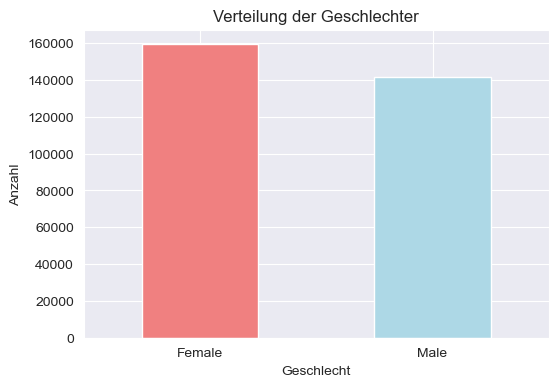

In [12]:

print("Geschlechterverteilung")
gender_counts = df['Sex'].value_counts()
gender_percent = df['Sex'].value_counts(normalize=True) * 100

for sex in gender_counts.index:
    print(f"{sex}: {gender_counts[sex]} Patienten ({gender_percent[sex]:.2f}%)")

plt.figure(figsize=(6,4))
gender_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Verteilung der Geschlechter')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.show()


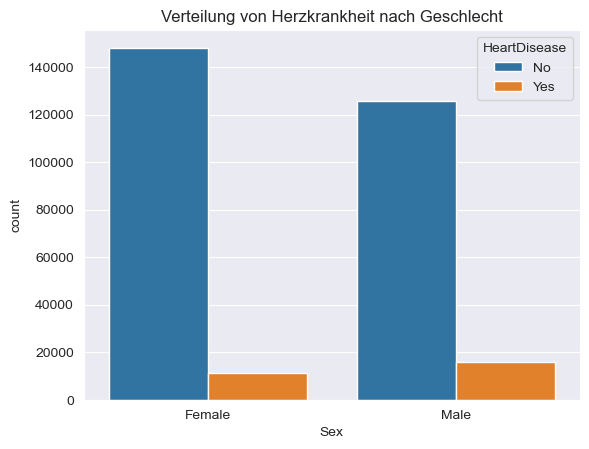

HeartDisease        No       Yes
Sex                             
Female        0.929885  0.070115
Male          0.887083  0.112917


In [13]:
sns.countplot(data=df, x='Sex', hue='HeartDisease')
plt.title("Verteilung von Herzkrankheit nach Geschlecht")
plt.show()

print(df.groupby("Sex")["HeartDisease"].value_counts(normalize=True).unstack())


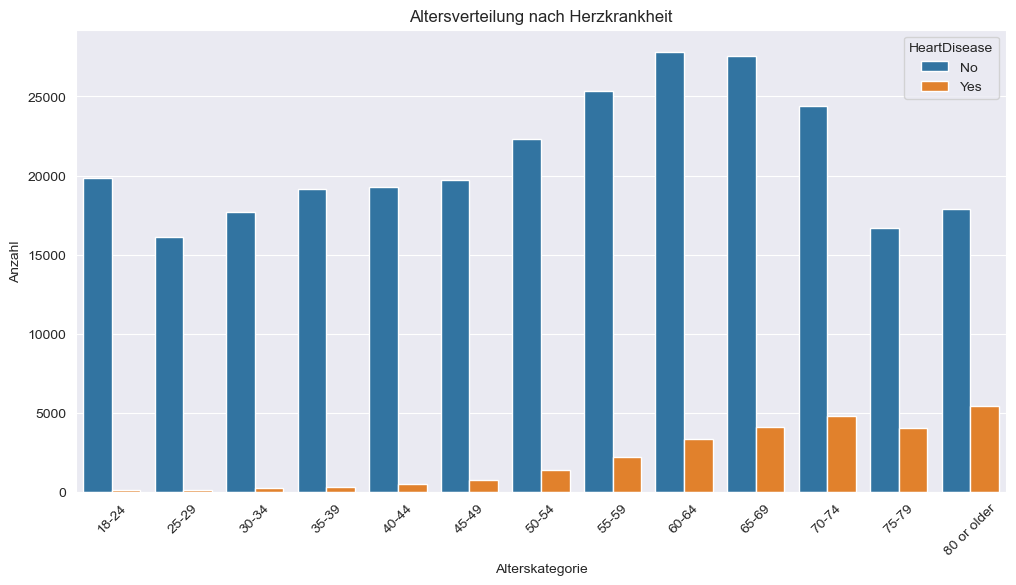

AgeCategory
18-24           0.63%
25-29           0.82%
30-34           1.25%
35-39           1.51%
40-44           2.45%
45-49           3.61%
50-54           5.81%
55-59           7.95%
60-64          10.62%
65-69          12.86%
70-74          16.45%
75-79          19.42%
80 or older    23.23%
Name: HeartDisease, dtype: object


In [14]:

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='AgeCategory', hue='HeartDisease', order=age_order)
plt.title("Altersverteilung nach Herzkrankheit")
plt.xlabel("Alterskategorie")
plt.ylabel("Anzahl")
plt.xticks(rotation=45)
plt.show()

# Anteil der 'Yes'-Werte pro Alterskategorie
heart_disease_by_age = df.groupby("AgeCategory")["HeartDisease"].apply(lambda x: (x == "Yes").mean())

# Optionale Ausgabe in Prozent:
print(heart_disease_by_age.apply(lambda x: f"{x*100:.2f}%"))


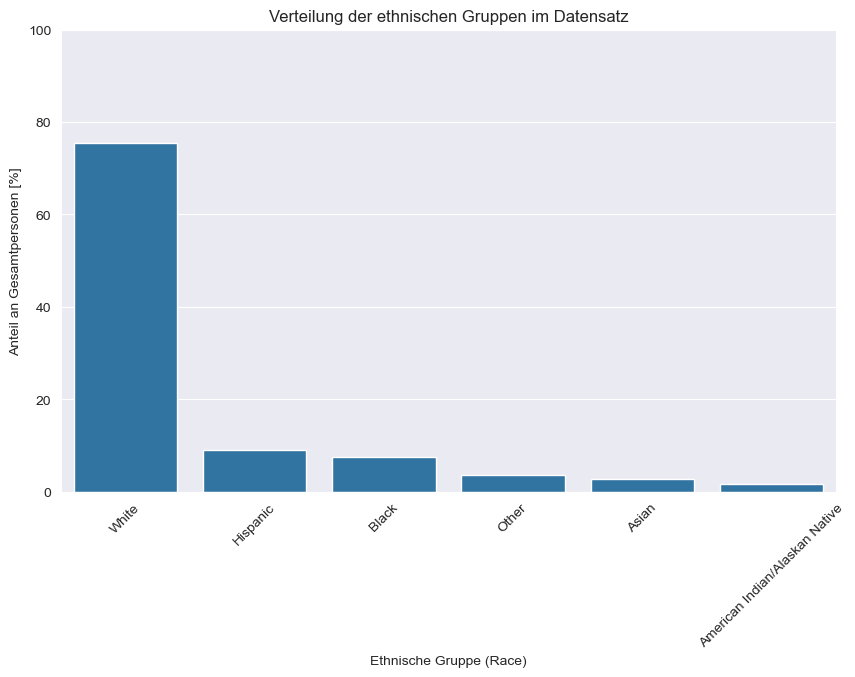

In [15]:
# Verteilung von Race
race_counts = df["Race"].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=race_counts.index, y=race_counts.values)
plt.title("Verteilung der ethnischen Gruppen im Datensatz")
plt.xlabel("Ethnische Gruppe (Race)")
plt.ylabel("Anteil an Gesamtpersonen [%]")
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.show()

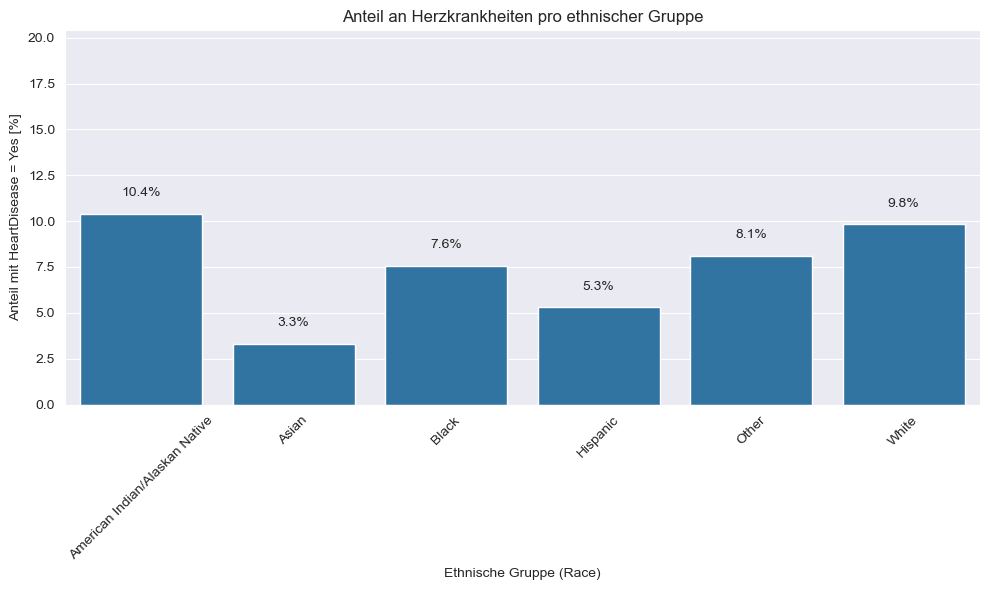

In [16]:

heart_disease_rates = df.groupby("Race")["HeartDisease"].apply(lambda x: (x == "Yes").mean()) * 100

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=heart_disease_rates.index, y=heart_disease_rates.values)

# Prozentzahlen über den Balken anzeigen
for i, value in enumerate(heart_disease_rates.values):
    ax.text(i, value + 0.8, f"{value:.1f}%", ha='center', va='bottom', fontsize=10)

plt.title("Anteil an Herzkrankheiten pro ethnischer Gruppe")
plt.xlabel("Ethnische Gruppe (Race)")
plt.ylabel("Anteil mit HeartDisease = Yes [%]")
plt.xticks(rotation=45)
plt.ylim(0, heart_disease_rates.max() + 10)
plt.tight_layout()
plt.show()

In [17]:
df = df.drop(columns=['Race'])

## Binärisierung

In [18]:
binary_map = {"No": 0, "Yes": 1}
binary_columns = ["HeartDisease","Smoking", "AlcoholDrinking", "Stroke", "DiffWalking",
                  "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]

for col in binary_columns:
    df[col] = df[col].map(binary_map)

df["Diabetic"] = df["Diabetic"].apply(lambda x: 0 if x == "No" else 1)


genhealth_map = {
        'Excellent': 4,
        'Very good': 3,
        'Good': 2,
        'Fair': 1,
        'Poor': 0
    }
df["GenHealth"] = df["GenHealth"].map(genhealth_map)
df["Sex"] = df["Sex"].map({"Female": 0, "Male": 1})

def age_to_mid(age):
        if "or older" in age:
            return 85
        low, high = map(int, age.split("-"))
        return (low + high) / 2

df["Age"] = df["AgeCategory"].apply(age_to_mid)
df.drop("AgeCategory", axis=1, inplace=True)

## Feauture Engineering

In [19]:
def bmi_category_code(bmi):
    if bmi < 18.5:
        return 15.5      # Untergewicht
    elif bmi < 25:
        return 22.5  # Normalgewicht
    elif bmi < 30:
        return 27.5  # Präadipositas
    elif bmi < 35:
        return 32.5  # Adipositas Grad I
    elif bmi < 40:
        return 37.5  # Adipositas Grad II
    else:
        return 55  # Adipositas Grad III

df['BMI'] = df['BMI'].apply(bmi_category_code)

## Skalierung

In [20]:
# Skalierung
scaler = MinMaxScaler()
scale_cols = ["BMI", "PhysicalHealth", "MentalHealth", "SleepTime", "Age"]
df[scale_cols] = scaler.fit_transform(df[scale_cols])

## Daten nach der Voverarbeitung

In [21]:
styled_df_after = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df_after

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Age
0,0,0.000000,1,0,0,0.100000,1.000000,0,0,1,1,3,0.187500,1,0,1,0.562500
1,0,0.177215,0,0,1,0.000000,0.000000,0,0,0,1,3,0.312500,0,0,0,1.000000
2,0,0.303797,1,0,0,0.666667,1.000000,0,1,1,1,1,0.375000,1,0,0,0.718750
3,0,0.177215,0,0,0,0.000000,0.000000,0,0,0,0,2,0.250000,0,0,1,0.875000
4,0,0.177215,0,0,0,0.933333,0.000000,1,0,0,1,3,0.375000,0,0,0,0.328125
5,1,0.303797,1,0,0,0.200000,0.000000,1,0,0,0,1,0.625000,0,0,0,0.875000
6,0,0.177215,0,0,0,0.500000,0.000000,0,0,0,1,1,0.125000,1,0,1,0.796875
7,0,0.430380,1,0,0,0.166667,0.000000,1,0,1,0,2,0.437500,1,0,0,1.000000
8,0,0.303797,0,0,0,0.000000,0.000000,0,0,1,0,1,0.187500,0,1,0,1.000000
9,0,1.000000,0,0,0,0.000000,0.000000,1,1,0,1,2,0.500000,0,0,0,0.718750


# Machine Learning

In [22]:
X = df.drop('HeartDisease', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Logistische Regression
Logistische Regression mit Balanced, zum ausgleich der wenigen erkankten

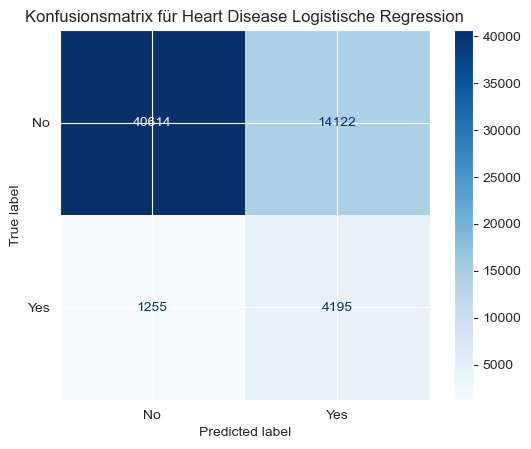

Genauigkeit: 0.7445086897285083
Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.789371   0.206696  0.689625  0.318061        0.237642
1    0.694251   0.244703  0.826688  0.377626        0.379060
Demographic Parity Difference: 0.141


In [23]:
#Logistische Regression
X = df.drop('HeartDisease', axis=1)
X = pd.get_dummies(X, drop_first=True)

y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

modelLogistic = LogisticRegression(max_iter=1000, class_weight='balanced')
modelLogistic.fit(X_train, y_train)

y_pred = modelLogistic.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Logistische Regression')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print("Genauigkeit:", accuracy)

# Wiederhole Vorhersagen
y_pred = modelLogistic.predict(X_test)

# Sensitives Merkmal extrahieren (Sex)
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)

print("Fairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

### Relevanz der Daten nach Permutation

Age: 0.0204 ± 0.0014
Sex: 0.0087 ± 0.0007
Stroke: 0.0052 ± 0.0002
GenHealth: 0.0017 ± 0.0009
KidneyDisease: 0.0012 ± 0.0004
MentalHealth: 0.0011 ± 0.0003
Asthma: 0.0010 ± 0.0003
PhysicalActivity: 0.0003 ± 0.0001
PhysicalHealth: 0.0000 ± 0.0002
AlcoholDrinking: -0.0001 ± 0.0002
SleepTime: -0.0002 ± 0.0002
BMI: -0.0006 ± 0.0003
SkinCancer: -0.0007 ± 0.0002
DiffWalking: -0.0008 ± 0.0004
Smoking: -0.0023 ± 0.0006
Diabetic: -0.0024 ± 0.0004


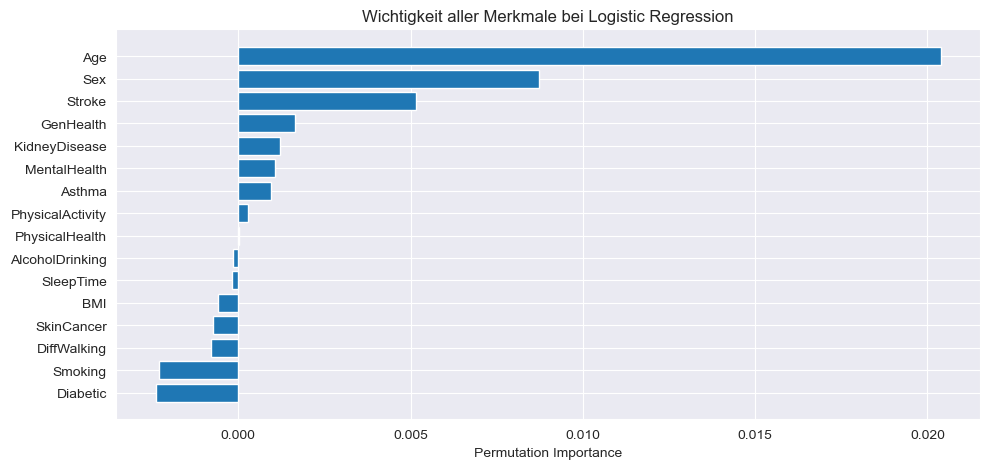

In [24]:
result = permutation_importance(modelLogistic, X_test, y_test, n_repeats=15, random_state=42, scoring='accuracy')
sorted_idx = result.importances_mean.argsort()[::-1]

for i in sorted_idx:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

plt.figure(figsize=(10, len(X_test.columns) * 0.3))
plt.barh(X_test.columns[sorted_idx][::-1], result.importances_mean[sorted_idx][::-1])
plt.xlabel("Permutation Importance")
plt.title("Wichtigkeit aller Merkmale bei Logistic Regression")
plt.tight_layout()
plt.show()

### SHAP Analyse

In [25]:
explainer_lr = shap.Explainer(modelLogistic, X_train)
shap_values_lr = explainer_lr(X_test)

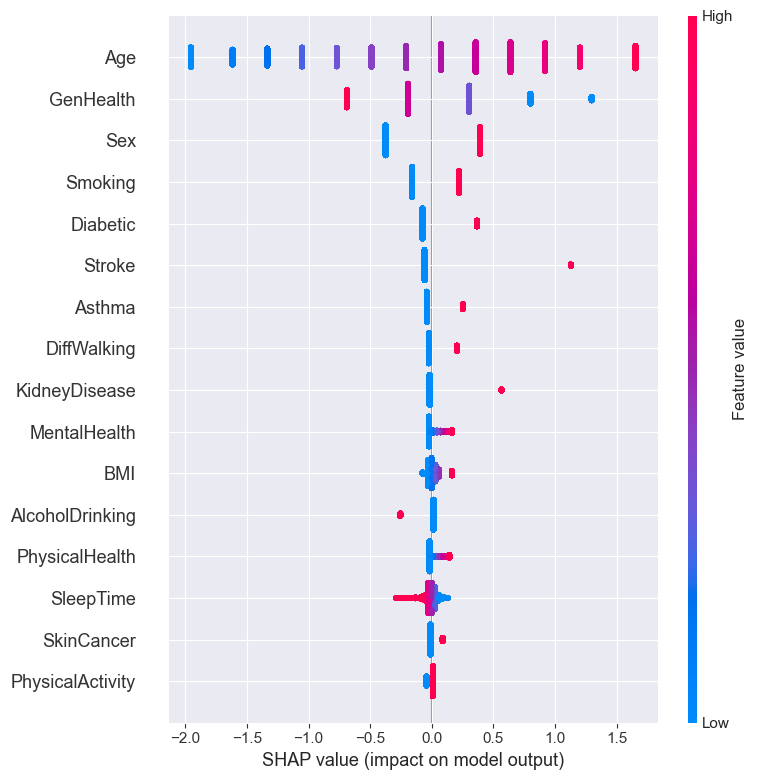

In [26]:
shap.summary_plot(shap_values_lr, X_test)

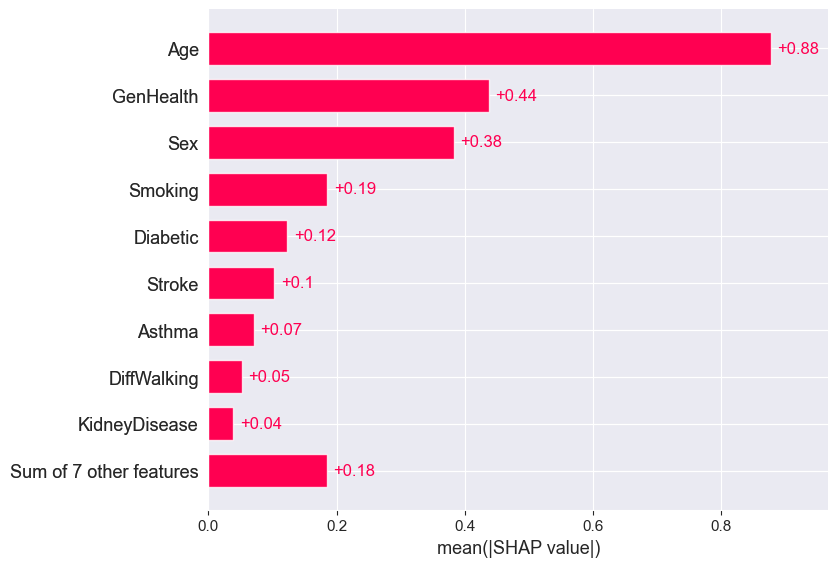

In [27]:
shap.plots.bar(shap_values_lr)

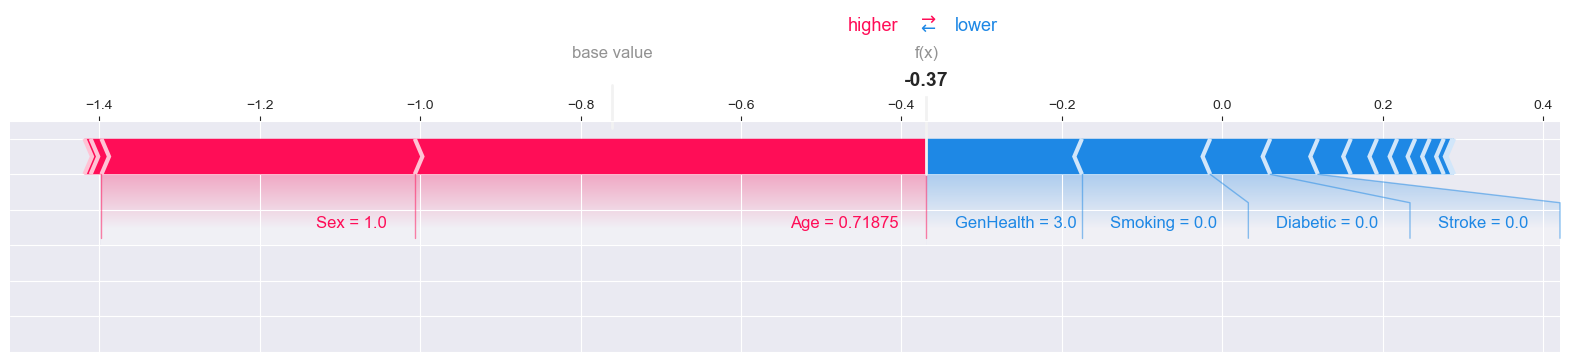

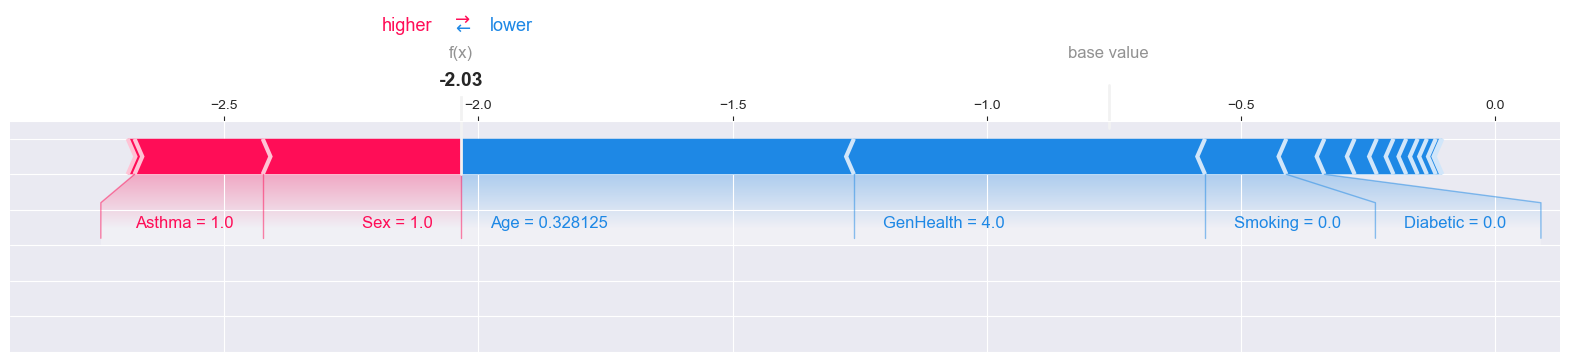

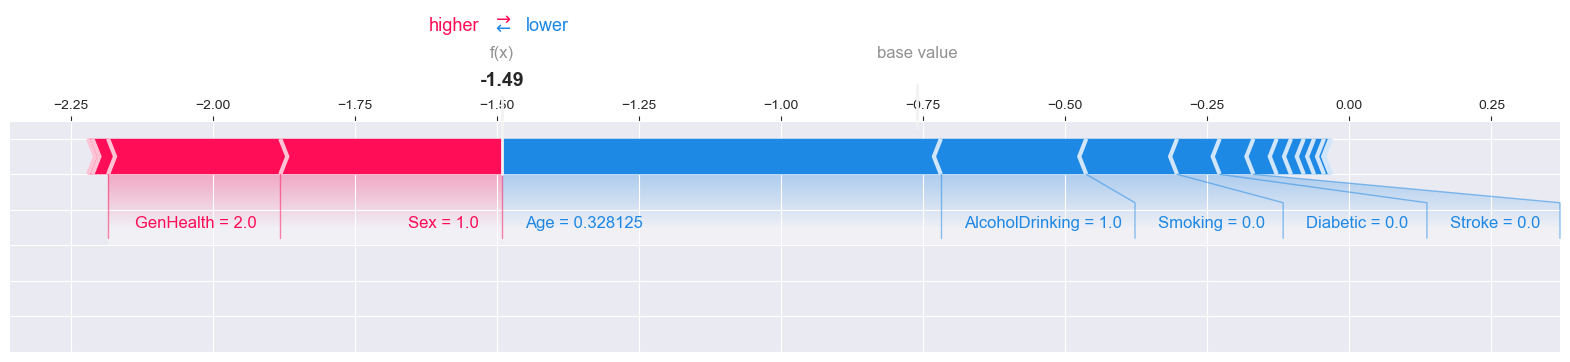

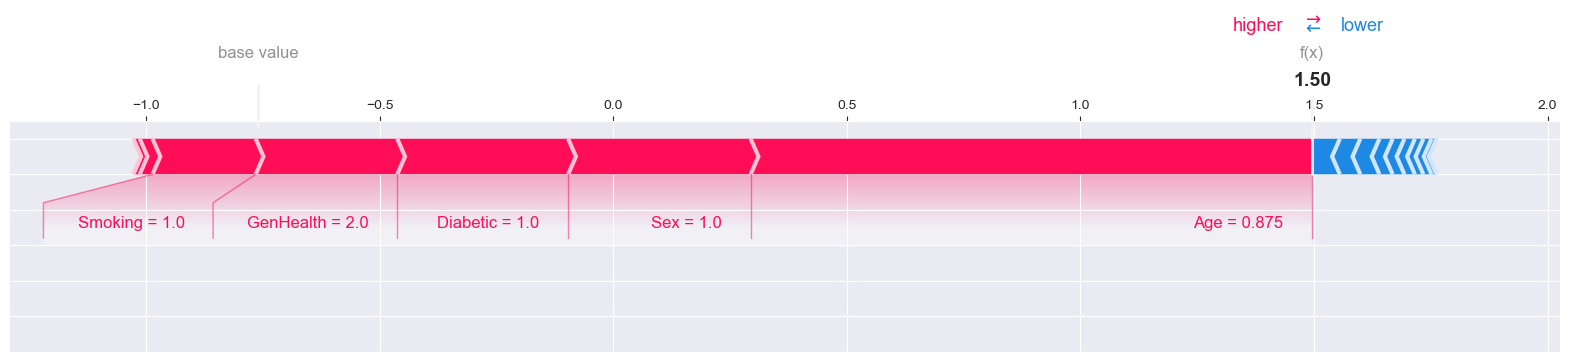

In [28]:
indices = [7, 8, 9, 10]
for index in indices:
    shap.plots.force(shap_values_lr[index], matplotlib=True)

## Random Forrest

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Beste Parameterkombination:
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


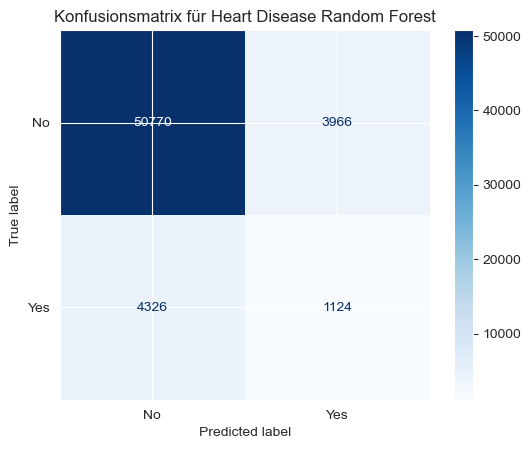

Genauigkeit: 0.8622270960023926


In [29]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)
best_forest_model = grid_search.best_estimator_

print("Beste Parameterkombination:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_rand = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Random Forest')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)


### Fairness Analyse

In [30]:
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.900975   0.165658  0.096689  0.122108        0.041572
1    0.818819   0.240180  0.284144  0.260319        0.132741
Demographic Parity Difference: 0.091


### Relevanz der Daten nach Permutation

Age: 0.0042 ± 0.0010
GenHealth: 0.0031 ± 0.0008
Sex: 0.0015 ± 0.0007
SkinCancer: 0.0015 ± 0.0004
Stroke: 0.0010 ± 0.0002
Diabetic: -0.0000 ± 0.0004
KidneyDisease: -0.0003 ± 0.0002
AlcoholDrinking: -0.0005 ± 0.0003
Smoking: -0.0006 ± 0.0006
PhysicalActivity: -0.0009 ± 0.0003
Asthma: -0.0015 ± 0.0004
DiffWalking: -0.0020 ± 0.0005
SleepTime: -0.0020 ± 0.0007
BMI: -0.0033 ± 0.0010
PhysicalHealth: -0.0054 ± 0.0006
MentalHealth: -0.0079 ± 0.0004


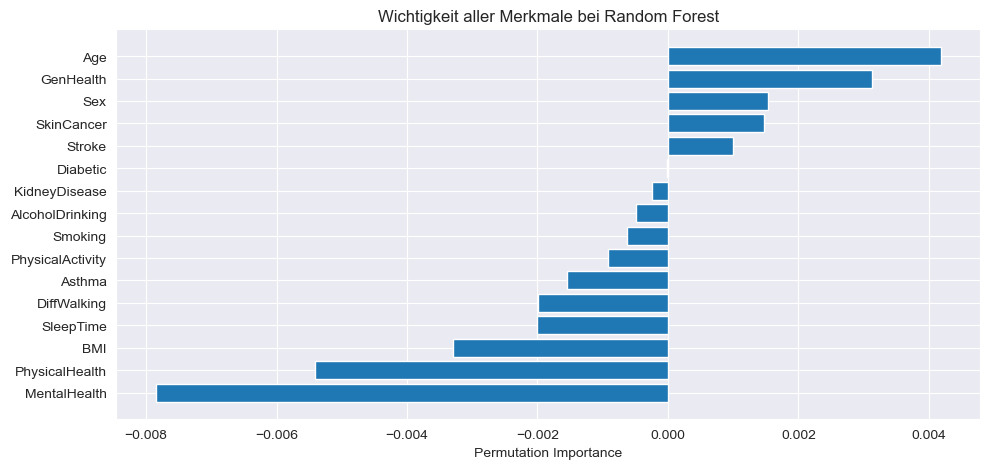

In [31]:
result = permutation_importance(best_forest_model, X_test, y_test, n_repeats=15, random_state=42, scoring='accuracy')
sorted_idx = result.importances_mean.argsort()[::-1]

for i in sorted_idx:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

plt.figure(figsize=(10, len(X_test.columns) * 0.3))  # Dynamische Höhe je nach Anzahl Features
plt.barh(X_test.columns[sorted_idx][::-1], result.importances_mean[sorted_idx][::-1])
plt.xlabel("Permutation Importance")
plt.title("Wichtigkeit aller Merkmale bei Random Forest")
plt.tight_layout()
plt.show()


### SHAP Analyse

In [32]:
X_sample = X_test.sample(n=1000, random_state=42)
explainer_rf = shap.TreeExplainer(best_model)
shap_values_rf = explainer_rf(X_sample, check_additivity=False)

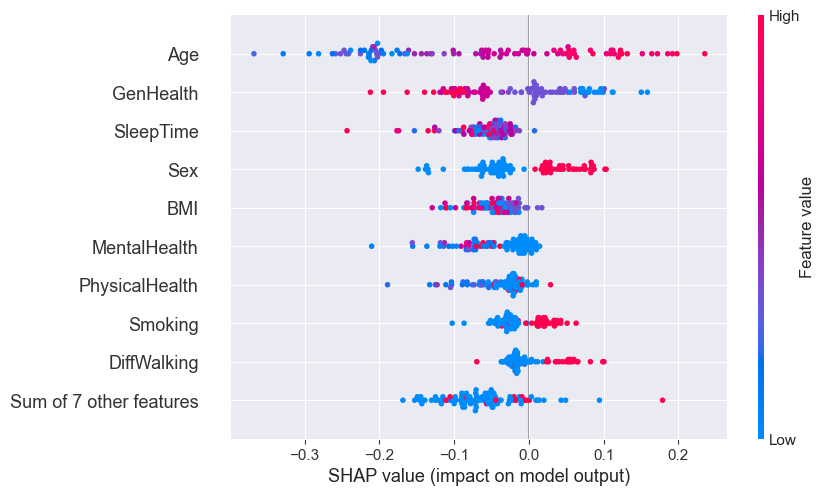

In [33]:
shap.plots.beeswarm(shap_values_rf[:, :, 1])

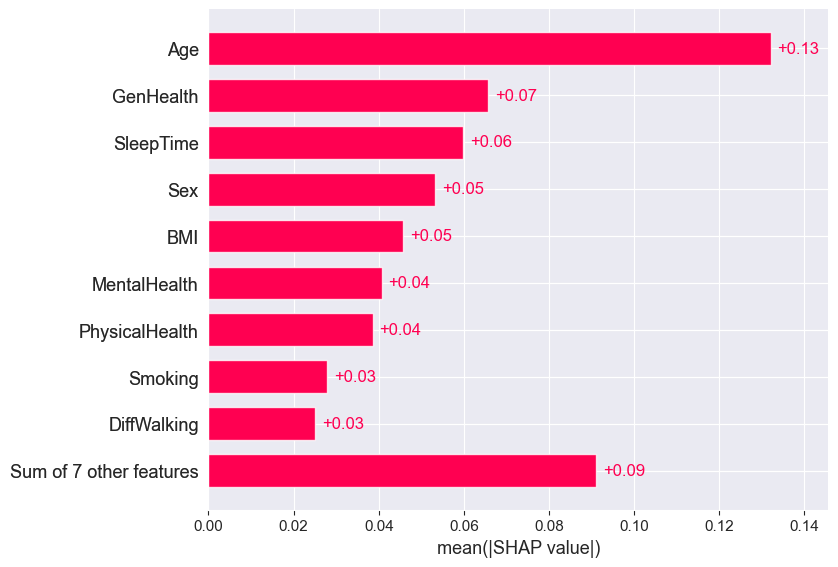

In [34]:
shap.plots.bar(shap_values_rf[:, :, 1])

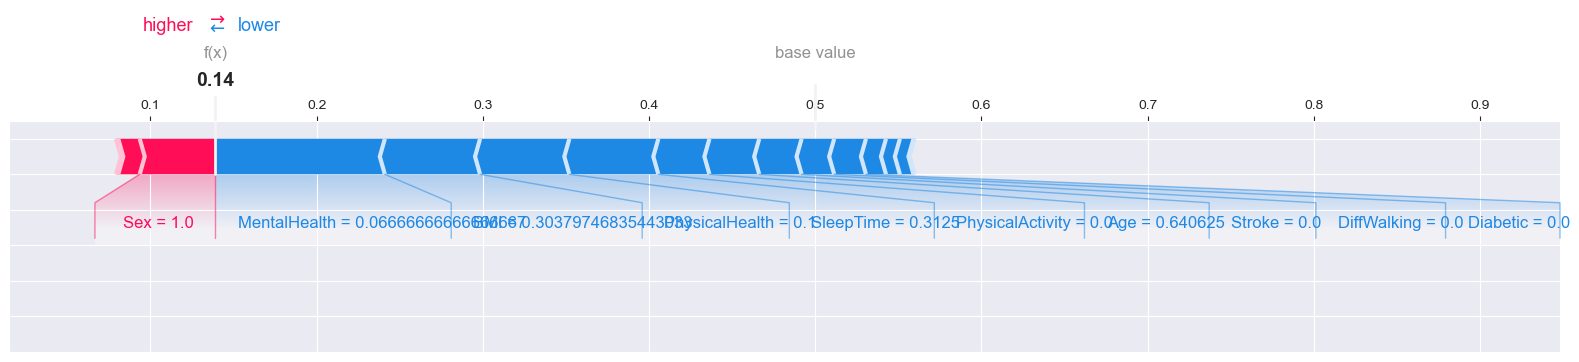

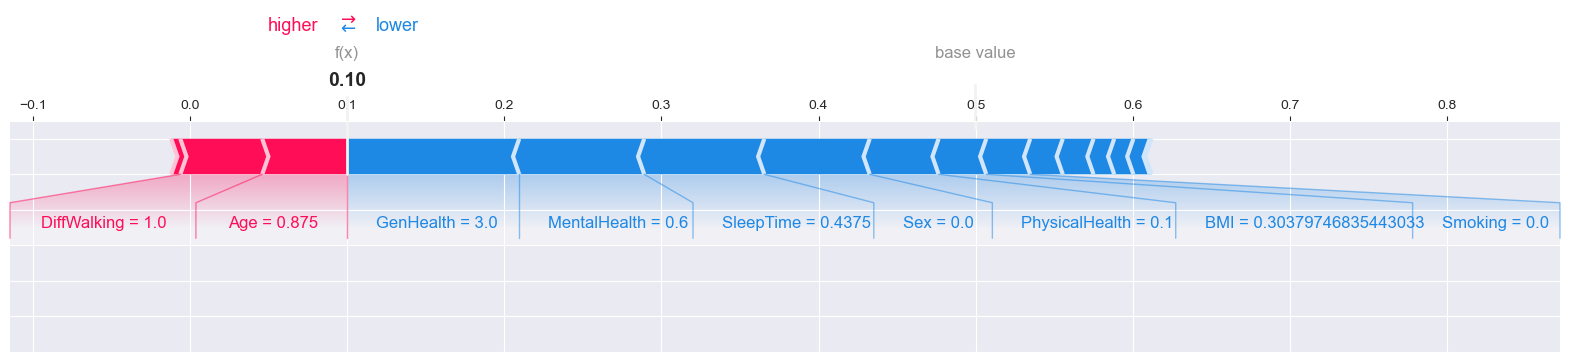

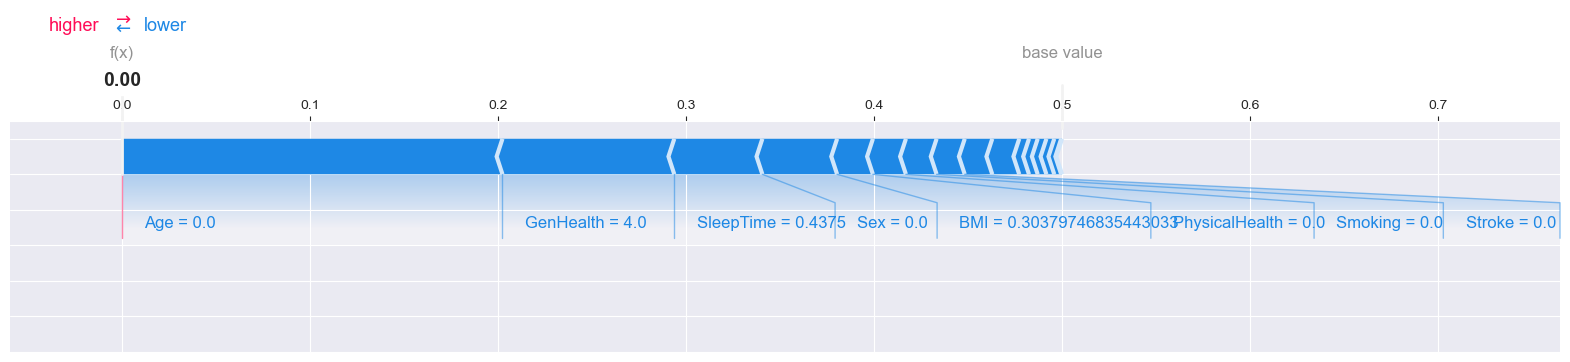

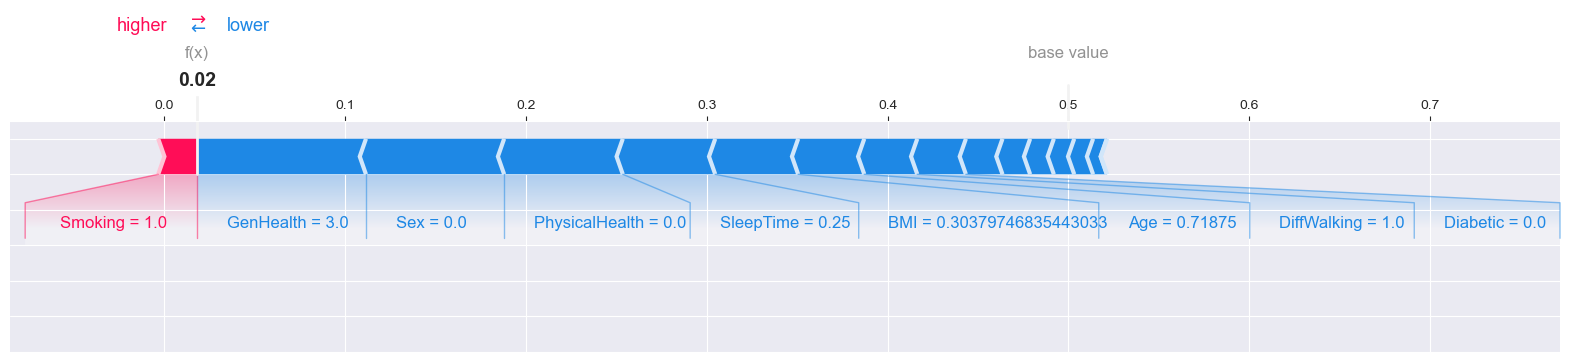

In [35]:
indices = [7, 8, 9, 10]

for i, index in enumerate(indices):
    shap.plots.force(shap_values_rf[index, :, 1], matplotlib=True)

## Stacking mit logistischer Regression und Random Forrest als Base Model, und LR als Meta Modell

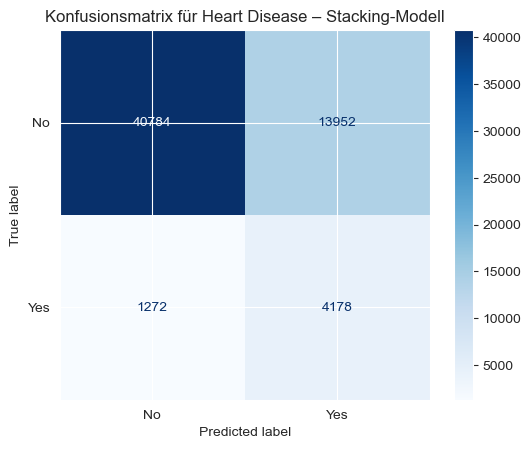

Genauigkeit (Stacking): 0.747050809158276

Fairness-Analyse nach 'Sex' (Stacking):
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.793302   0.208683  0.681236  0.319495        0.232516
1    0.695237   0.245436  0.827316  0.378565        0.378215
Demographic Parity Difference: 0.146


In [36]:
#Stacking lr und rf als base model, lr als meta

# Basismodelle (schon trainiert mit SMOTE)
estimators = [
    ('rf', best_forest_model),
    ('lr', modelLogistic)
]

# Meta-Modell: Logistische Regression
final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced')

# Stacking-Classifier
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,  # wenn True werden auch Original-Features aus dem Meta-Modell übergeben
    n_jobs=-1
)

# Stacking-Modell (smote Trainingsdaten)
stacked_model.fit(X_train, y_train)

#  Vorhersage auf Testdaten
y_pred_stack = stacked_model.predict(X_test)


# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – Stacking-Modell')
plt.show()

accuracy = accuracy_score(y_test, y_pred_stack)
print("Genauigkeit (Stacking):", accuracy)

# Fairness-Analyse
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}
# nach Geschlecht
frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (Stacking):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

## XGB Boost

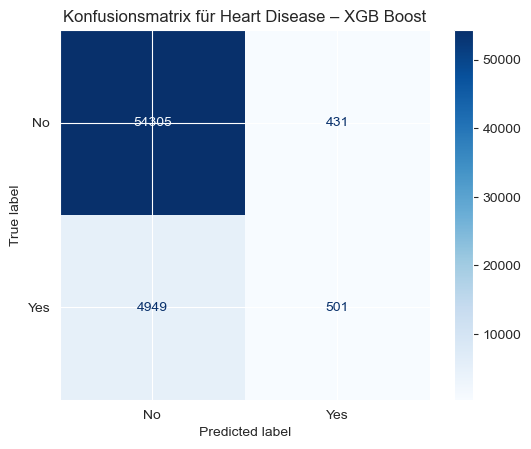

Genauigkeit (Stacking): 0.7478981823015319


In [44]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – XGB Boost')
plt.show()

accuracy = accuracy_score(y_test, y_pred_stack)
print("Genauigkeit (Stacking):", accuracy)

### Fairness Analyse nach Geschlecht

In [38]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (XGB Boost):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


Fairness-Analyse nach 'Sex' (XGB Boost):
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.793302   0.208683  0.681236  0.319495        0.232516
1    0.695237   0.245436  0.827316  0.378565        0.378215
Demographic Parity Difference: 0.146


### Shap Analyse

100%|===================| 60033/60186 [02:42<00:00]        

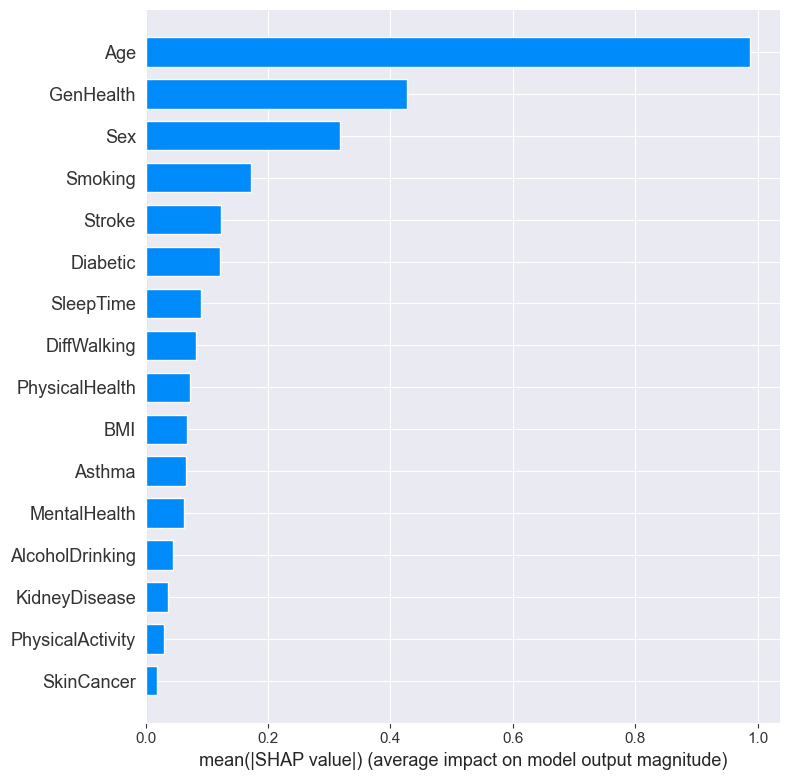

In [39]:
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)

shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")

## Stacking mit logistischer Regression, Random Forrest und XG boost als Base Model, und LR als Meta Modell

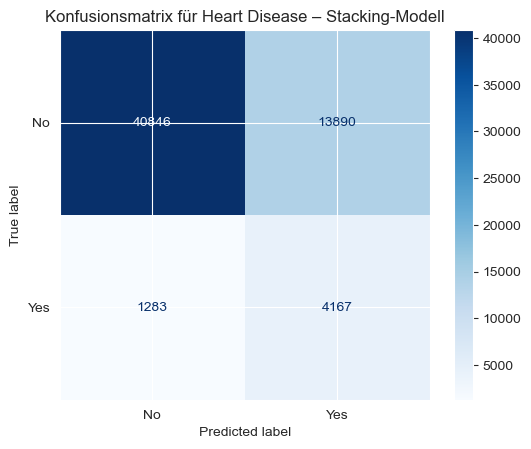

Genauigkeit (Stacking): 0.7478981823015319

Fairness-Analyse nach 'Sex' (Stacking):
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.794277   0.209087  0.678587  0.319676        0.231164
1    0.695942   0.245657  0.825746  0.378662        0.377158
Demographic Parity Difference: 0.146


In [40]:
estimators = [
    ('rf', best_forest_model),
    ('lr', modelLogistic),
    ('xgb', xgb_model)
]

# Meta-Modell: Logistische Regression
final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced')

# Stacking-Classifier
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,  # wenn True werden auch Original-Features aus dem Meta-Modell übergeben
    n_jobs=-1
)

# Stacking-Modell ()
stacked_model.fit(X_train, y_train)

#  Vorhersage auf Testdaten
y_pred_stack = stacked_model.predict(X_test)

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – Stacking-Modell')
plt.show()

accuracy = accuracy_score(y_test, y_pred_stack)
print("Genauigkeit (Stacking):", accuracy)

# Fairness-Analyse
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}
# nach Geschlecht
frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (Stacking):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

### Impact der einzelnen Modelle

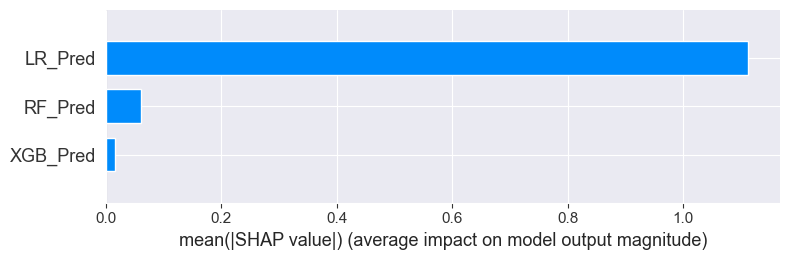

In [45]:
rf_pred = best_forest_model.predict_proba(X_test)[:, 1]
lr_pred = modelLogistic.predict_proba(X_test)[:, 1]
xgb_pred = xgb_model.predict_proba(X_test)[:, 1]

meta_features = np.column_stack((rf_pred, lr_pred, xgb_pred))

explainer = shap.Explainer(stacked_model.final_estimator_, meta_features)
shap_values = explainer(meta_features)
feature_names = ["RF_Pred", "LR_Pred", "XGB_Pred"]
shap.summary_plot(shap_values, features=meta_features, feature_names=feature_names, plot_type="bar")

## Voting

### Hart Voting

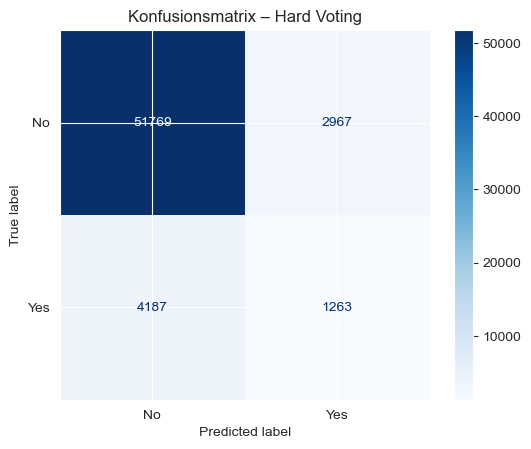

In [46]:
from sklearn.ensemble import VotingClassifier

voting_model_hard = VotingClassifier(
    estimators=[
        ('rf', best_forest_model),
        ('lr', modelLogistic),
        ('xgb', xgb_model)
    ],
    voting='hard',
    n_jobs=-1
)

voting_model_hard.fit(X_train, y_train)

y_pred_hard = voting_model_hard.predict(X_test)

cm_hard = confusion_matrix(y_test, y_pred_hard)
disp_hard = ConfusionMatrixDisplay(confusion_matrix=cm_hard, display_labels=['No', 'Yes'])
disp_hard.plot(cmap='Blues')
plt.title("Konfusionsmatrix – Hard Voting")
plt.show()

### Soft voting

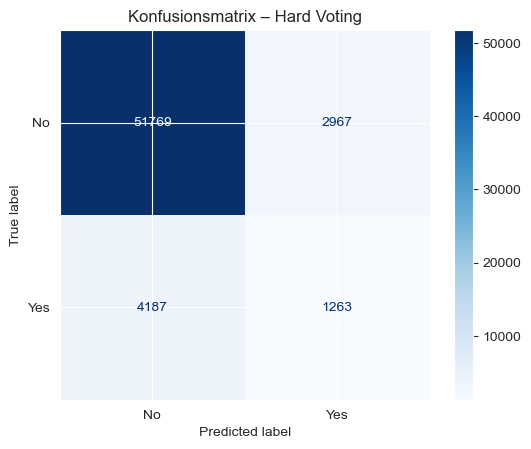

In [47]:
voting_model_soft = VotingClassifier(
    estimators=[
        ('rf', best_forest_model),
        ('lr', modelLogistic),
        ('xgb', xgb_model)
    ],
    voting='soft',
    n_jobs=-1
)

voting_model_soft.fit(X_train, y_train)

y_pred_soft = voting_model_hard.predict(X_test)

y_proba_soft = voting_model_soft.predict_proba(X_test)[:, 1]

cm_soft = confusion_matrix(y_test, y_pred_soft)
disp_soft = ConfusionMatrixDisplay(confusion_matrix=cm_soft, display_labels=['No', 'Yes'])
disp_soft.plot(cmap='Blues')
plt.title("Konfusionsmatrix – Hard Voting")
plt.show()

### Vergleich Hart und Soft

In [48]:
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate(name, y_true, y_pred, y_prob=None):
    print(f" {name}")
    print(f"  Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"  Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"  Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"  F1 Score:  {f1_score(y_true, y_pred):.4f}")
    if y_prob is not None:
        print(f"  AUC:       {roc_auc_score(y_true, y_prob):.4f}")
    print()

evaluate("Hard Voting", y_test, y_pred_hard)
evaluate("Soft Voting", y_test, y_pred_soft, y_proba_soft)


🔸 Hard Voting
  Accuracy:  0.8811
  Precision: 0.2986
  Recall:    0.2317
  F1 Score:  0.2610

🔸 Soft Voting
  Accuracy:  0.8811
  Precision: 0.2986
  Recall:    0.2317
  F1 Score:  0.2610
  AUC:       0.8229



# Vergleich Merkmale 3 Modell

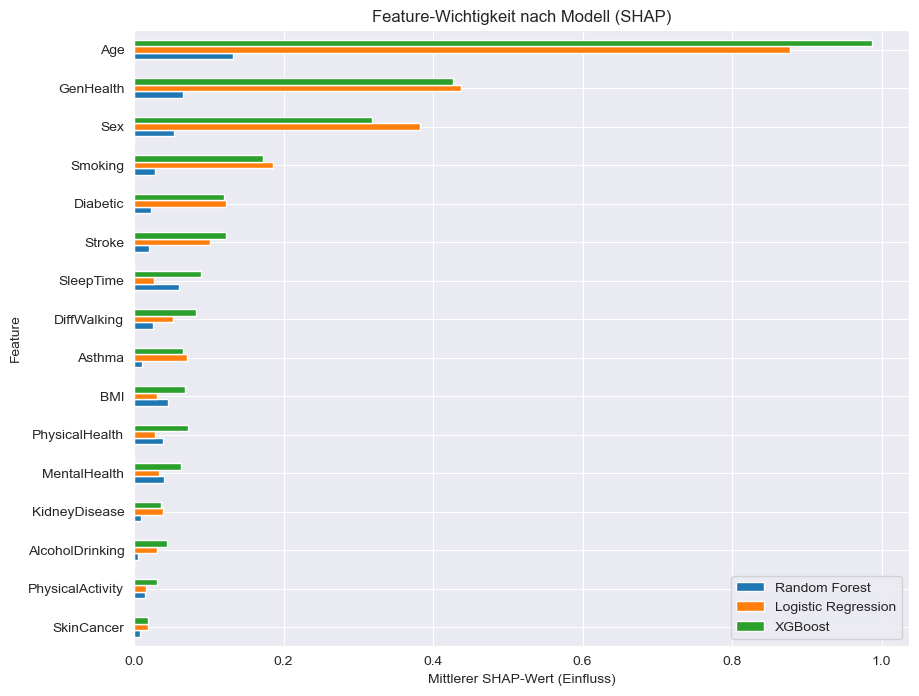

In [49]:

mean_rf = np.abs(shap_values_rf.values[:, :, 1]).mean(axis=0)
mean_lr = np.abs(shap_values_lr.values).mean(axis=0)
mean_xgb = np.abs(shap_values_xgb.values).mean(axis=0)

shap_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Random Forest": mean_rf,
    "Logistic Regression": mean_lr,
    "XGBoost": mean_xgb
}).set_index("Feature")


shap_df["Mean"] = shap_df.mean(axis=1)
shap_df = shap_df.sort_values("Mean")

shap_df.drop(columns="Mean").plot(kind="barh", figsize=(10, 8), title="Feature-Wichtigkeit nach Modell (SHAP)")
plt.xlabel("Mittlerer SHAP-Wert (Einfluss)")
plt.show()


# Erklärbarkeit auf eine Person

Index der ausgewählten Person: 55287
Vorhersagen für eine Testperson:
Random Forest:           Keine Krankheit
Logistische Regression:  Krankheit
XGBoost:                 Keine Krankheit
Voting:                  Keine Krankheit
Wahrer Wert:             Keine Krankheit


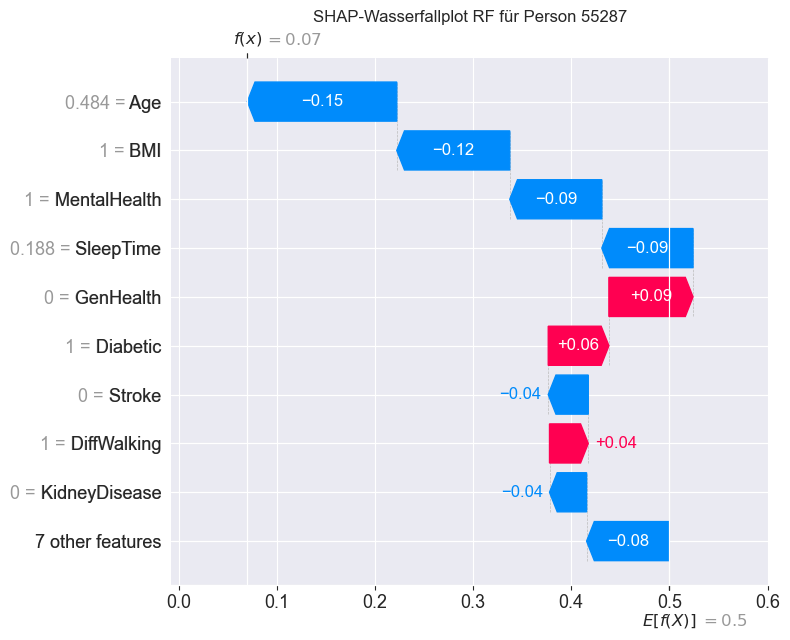

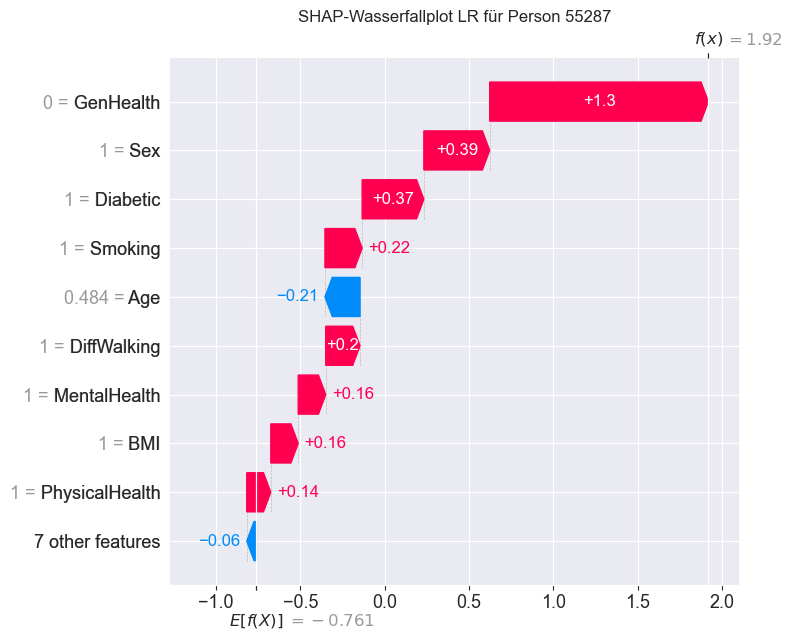

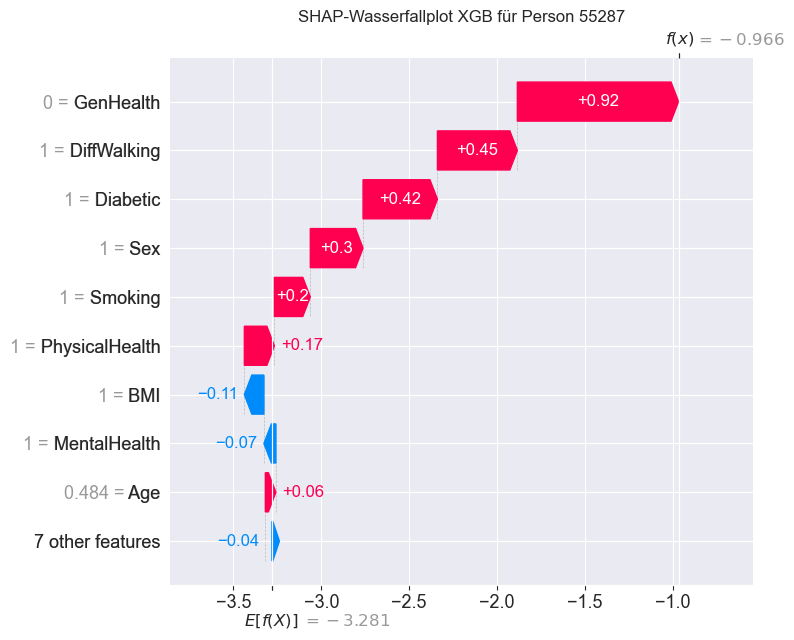

In [51]:
import random

idx = random.randint(0, X_test.shape[0] - 1)
#idx = 13
print(f"Index der ausgewählten Person: {idx}")
person = X_test.iloc[[idx]]

# Vorhersagen
pred_rf = best_forest_model.predict(person)[0]
pred_lr = modelLogistic.predict(person)[0]
pred_xgb = xgb_model.predict(person)[0]
pred_voting = voting_model_soft.predict(person)

print("Vorhersagen für eine Testperson:")
print(f"Random Forest:           {'Krankheit' if pred_rf == 1 else 'Keine Krankheit'}")
print(f"Logistische Regression:  {'Krankheit' if pred_lr == 1 else 'Keine Krankheit'}")
print(f"XGBoost:                 {'Krankheit' if pred_xgb == 1 else 'Keine Krankheit'}")
print(f"Voting:                  {'Krankheit' if pred_voting == 1 else 'Keine Krankheit'}")


true_label = y_test.iloc[idx]
print(f"Wahrer Wert:             {'Krankheit' if pred_rf == 1 else 'Keine Krankheit'}")

shap_val_rf = explainer_rf(person)
shap_val_lr = explainer_lr(person)
shap_val_xgb = explainer_xgb(person)


fig, ax = plt.subplots(figsize=(10, 15))
shap.plots.waterfall(shap_val_rf[0, :, 1], max_display=10, show=False)  # wichtig: show=False
plt.title(f"SHAP-Wasserfallplot RF für Person {idx}")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 15))
shap.plots.waterfall(shap_val_lr[0], max_display=10, show=False)
plt.title(f"SHAP-Wasserfallplot LR für Person {idx}")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 15))
shap.plots.waterfall(shap_val_xgb[0], max_display=10, show=False)
plt.title(f"SHAP-Wasserfallplot XGB für Person {idx}")
plt.tight_layout()
plt.show()
